In [1]:
import numpy as np
import registration as rgs
import vis_camera
import camera

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
####### REGISTRATION
print("Registration started")
#POINT CLOUD REGISTRATION 15 to 14
params = rgs.Params()
params.hist_name = "Hist_rmse_15_14"
params.source_dir = "/home/turin/Desktop/lizard_dataset_curated/2015/pcd15.pcd"
params.target_dir = "/home/turin/Desktop/lizard_dataset_curated/2014/pcd14.pcd"
trans_mat_15_14 = rgs.main(params)
#POINT CLOUD REGISTRATION 16 to 14
params = rgs.Params()
params.hist_name = "Hist_rmse_16_14"
params.source_dir = "/home/turin/Desktop/lizard_dataset_curated/2016/pcd16.pcd"
params.target_dir = "/home/turin/Desktop/lizard_dataset_curated/2014/pcd14.pcd"
trans_mat_16_14 = rgs.main(params)
print("Registration DONE")

Registration started
Global and Local Registration
:: Load two point clouds with initial pose.
:: Downsample with a voxel size 0.100.
:: Estimate normal with search radius 0.200.
:: Compute FPFH feature with search radius 0.300.
:: Downsample with a voxel size 0.100.
:: Estimate normal with search radius 0.200.
:: Compute FPFH feature with search radius 0.300.
:: Apply global registration with distance threshold 0.850
Iteration Index: 0, Scale Index: 0, Scale Iteration Index: 0, Fitness: 1.0, Inlier RMSE: 0.16105561071175042,
Iteration Index: 1, Scale Index: 0, Scale Iteration Index: 1, Fitness: 1.0, Inlier RMSE: 0.15807595057717672,
Iteration Index: 2, Scale Index: 0, Scale Iteration Index: 2, Fitness: 1.0, Inlier RMSE: 0.15680637879896223,
Iteration Index: 3, Scale Index: 0, Scale Iteration Index: 3, Fitness: 1.0, Inlier RMSE: 0.15607649498877424,
Iteration Index: 4, Scale Index: 0, Scale Iteration Index: 4, Fitness: 1.0, Inlier RMSE: 0.15558351882192617,
Iteration Index: 5, Scale In

FileExistsError: [Errno 17] File exists: 'result'

In [4]:
#VISUALIZATION
#GLOBAL SHIFT ACCORDING TO POINTCLOUD SHIFT
shift = np.asarray([332400, 8375600, 0.0])
#CAMERA FILES
camera14_xml = "/home/turin/Desktop/lizard_dataset_curated/2014/cam14.xml"
camera15_xml = "/home/turin/Desktop/lizard_dataset_curated/2015/cam15.xml"
camera16_xml = "/home/turin/Desktop/lizard_dataset_curated/2016/cam16.xml"
opencv_xml = "/home/turin/Desktop/lizard_dataset_curated/opencv_cam_calib.xml"
#FOR CAMERA14
camera_ref14 = camera.CameraRef(camera14_xml, opencv_xml)
camera14_set = []
for idx in range(len(camera_ref14.camera_dict)):
    camera14 = camera.Camera(camera_ref14.camera_dict[idx], camera_ref14.local2global, shift=shift)
    camera14_set.append(camera14.get_camera_set())

#FOR CAMERA15
camera_ref15 = camera.CameraRef(camera15_xml, opencv_xml)
camera15_set = []
for idx in range(len(camera_ref15.camera_dict)):
    camera15 = camera.Camera(camera_ref15.camera_dict[idx], camera_ref15.local2global, trans_mat_15_14, shift=shift)
    camera15_set.append(camera15.get_camera_set())

#FOR CAMERA16
camera_ref16 = camera.CameraRef(camera16_xml, opencv_xml)
camera16_set = []
for idx in range(len(camera_ref16.camera_dict)):
    camera16 = camera.Camera(camera_ref16.camera_dict[idx], camera_ref16.local2global, trans_mat_16_14, shift=shift)
    camera16_set.append(camera16.get_camera_set())
print("CAMERA DATA Preproccesing Done")



CAMERA DATA Preproccesing Done


In [7]:
import camera
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import argparse

"""
This script helps to visualize the camera position in the global map
1. pose2xyz: It is used to get 3D point from homohenous matrix
2. visualize_camera: Visualize Single camera in both 2D(x, y) and 3D(x, y, z) format
3. visualize_multi_camera: Visualize Multiple camera in both 2D(x, y) and 3D(x, y, z) format to compare relative position
"""
def pose2xyz(camera, shift=False):
    xyz_list = []
    if shift:
        for idx in range(len(camera)):
            xyz = np.subtract(camera[idx][1][:3, 3], np.asarray([[332400], [8375600], [0]]))
            xyz = [float(x) for x in xyz]
            xyz_list.append(xyz)
    else:
        for idx in range(len(camera)):
            xyz = camera[idx][1][:3, 3]
            xyz = [float(x) for x in xyz]
            xyz_list.append(xyz)
    xyz_np = np.asarray(xyz_list, dtype="object")
    return xyz_np


def visualize_camera(xyz, mode="3d", filename=0):
    x = xyz[:, 0]
    y = xyz[:, 1]
    z = xyz[:, 2]
    # Create the figure and the 3D axes
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # Create the scatter plot
    # save file name in current time format if not specified in a folder name Result
    if mode == "2d":
        if filename == 0:
            now = datetime.now()
            filename = "result/" + now.strftime("%Y-%m-%d %H:%M:%S") + "_2d.png"
        else:
            filename = "result/" + filename + "_2d.png"
        scatter = ax.scatter(x, y, np.zeros(x.shape), c=z, cmap='viridis', s=.5, alpha=0.9)
        fig.colorbar(scatter, pad = 0.15, label = "Camera depth")
    else:
        if filename == 0:
            now = datetime.now()
            filename = "result/" + now.strftime("%Y-%m-%d %H:%M:%S") + "_3d.png"
        else:
            filename = "result/" + filename + "_3d.png"
        scatter = ax.scatter(x, y, z, c=z, cmap='viridis', s=.5, alpha=0.9)
        fig.colorbar(scatter, pad = 0.15, label = "Camera depth")

    # Set the axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    # Save the figure in high resolution
    if os.path.exists(os.getcwd() + "/result"):
        plt.savefig(filename, dpi=600)
    else:
        os.mkdir("result")
        plt.savefig(filename, dpi=600)
    # Show the plot
    plt.show()


def visualize_multi_camera(xyzs, label_name, mode="3d", filename=0):
    # Create the figure and the 3D axes
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # Create the scatter plot
    if mode == "2d":
        if filename == 0:
            now = datetime.now()
            filename = "result/" + now.strftime("%Y-%m-%d %H:%M:%S") + "multi_2d.png"
        else:
            filename = "result/" + filename + "_multi2d.png"
        for idx in range(len(xyzs)):
            xyz = xyzs[idx]
            x = xyz[:, 0]
            y = xyz[:, 1]
            z = xyz[:, 2]
            ax.scatter(x, y, np.zeros(x.shape), s=.5, alpha=0.9, label=label_name[idx])
    else:
        if filename == 0:
            now = datetime.now()
            filename = "result/" + now.strftime("%Y-%m-%d %H:%M:%S") + "_multi_3d.png"
        else:
            filename = "result/" + filename + "_multi_3d.png"
        for idx in range(len(xyzs)):
            xyz = xyzs[idx]
            x = xyz[:, 0]
            y = xyz[:, 1]
            z = xyz[:, 2]
            ax.scatter(x, y, z, s=.5, alpha=0.9, label = label_name[idx])

    # Set the axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    # Save the figure in high resolution
    if os.path.exists(os.getcwd() + "/result"):
        plt.savefig(filename, dpi=1200)
    else:
        os.mkdir("result")
        plt.savefig(filename, dpi=1200)
    # Show the plot
    plt.show()


def main(camera_sets, labels, shift = False):
    camera_xyz = []
    for idx in range(len(camera_sets)):
        #camera_set = camera.main(camera_xml[idx], opencv_xml[idx])
        camera_set = camera_sets[idx]
        xyz_1 = pose2xyz(camera_set, shift)
        camera_xyz.append(xyz_1)
        visualize_camera(xyz_1, "2d", filename = labels[idx])
        visualize_camera(xyz_1, "3d", filename = labels[idx])
    if len(xyz_1)>1:
        visualize_multi_camera(camera_xyz, labels, "2d", "camera")
        visualize_multi_camera(camera_xyz, labels, "3d", "camera")

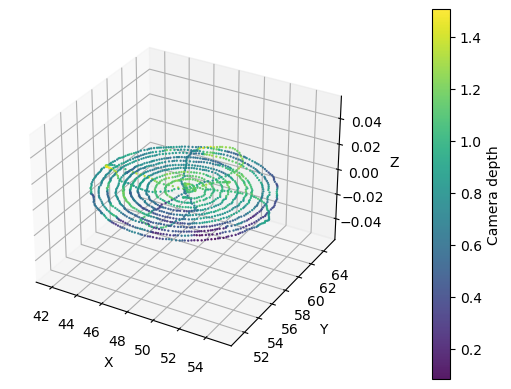

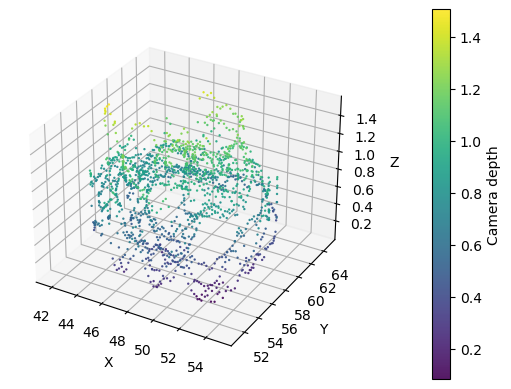

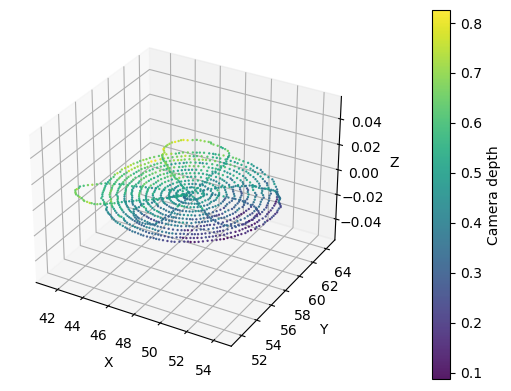

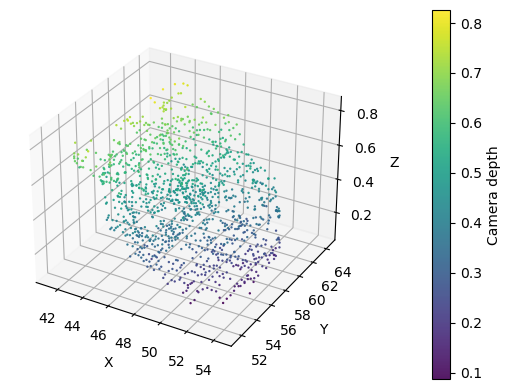

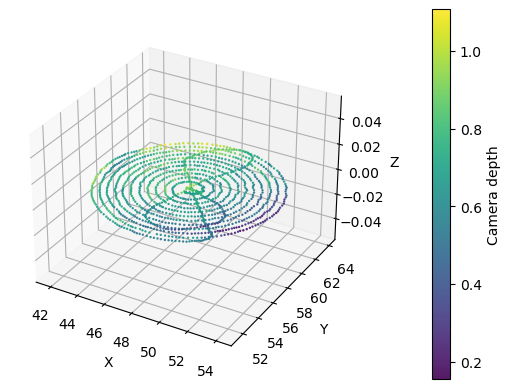

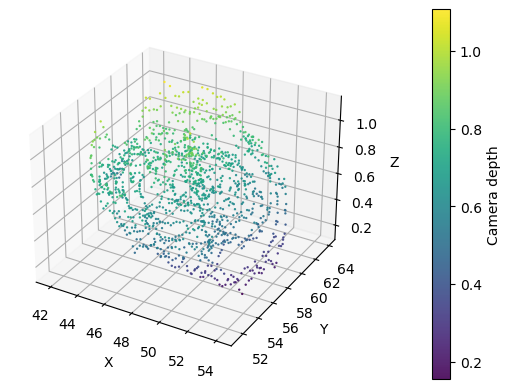

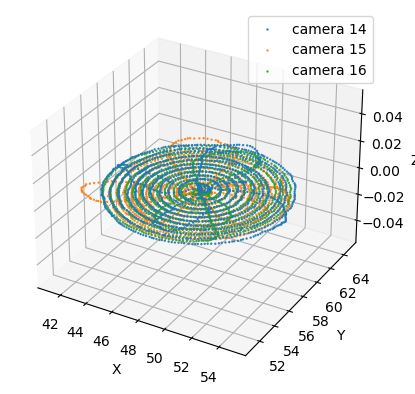

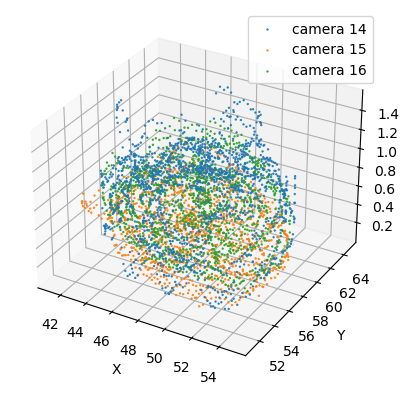

In [8]:
camera_xmls = [camera14_set, camera15_set, camera16_set]
labels = ["camera 14","camera 15", "camera 16"]
main(camera_xmls, labels, False)


In [5]:
import os
if not os.path.exists(os.getcwd() + "/result"):
    os.mkdir("result")